In [1]:
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.config.settings import FUNK_SVD_MODEL_DIR
from src.data.load_dataset import get_train_data, get_test_data, get_games_data
from src.evaluation.metrics import evaluate_recommendations
from src.models.recommender import GameRecommender

In [2]:
# Load data and initialize recommender
train_data = get_train_data()
test_data = get_test_data()
games_data = get_games_data()
print(f"Training: {len(train_data)} samples from {len(np.unique(train_data['UserId']))} users")
print(f"Testing: {len(test_data)} samples from {len(np.unique(test_data['UserId']))} users")

instance = GameRecommender(train_data, test_data, games_data)
instance.load(FUNK_SVD_MODEL_DIR)


Training: 81142 samples from 960 users
Testing: 18858 samples from 885 users


2025-05-01 18:46:04.689 | DEBUG    | src.models.funk_svd:load_model:291 - Loading models from C:\Ukma\coursework\funk-svd\data\models\funk_svd


In [3]:
pprint(evaluate_recommendations(instance.model, train_data))

{'coverage': {10: 0.23806717737183264, 20: 0.23806717737183264},
 'ndcg': {10: np.float64(0.6631669442001684),
          20: np.float64(0.727730764533957)},
 'precision': {10: 0.9159374999999962, 20: 0.8706420154797212},
 'recall': {10: 0.30874314223638527, 20: 0.5531420895510233}}


In [3]:
# Core analysis functions
def analyze_user_predictions(user_id):
    """Analyze predictions for a single user without generating recommendations"""
    user_id = int(user_id)

    # Get test items for this user using DataFrame filtering
    user_test_items = test_data[test_data['UserId'] == user_id]
    if user_test_items.empty:
        return pd.DataFrame()

    # Get predictions
    item_ids = user_test_items['BGGId'].astype(int).tolist()
    predictions = instance.get_predictions(user_id, item_ids)

    # Process results
    results = []
    for _, item in user_test_items.iterrows():
        item_id = int(item['BGGId'])
        if item_id in predictions:
            results.append({
                'ItemId': item_id,
                'Actual': float(item['Rating']),
                'Predicted': float(predictions[item_id]),
                'Error': float(item['Rating']) - float(predictions[item_id])
            })

    return pd.DataFrame(results)


def analyze_users(max_users=100):
    """Analyze a sample of users - only predictions, no recommendations"""
    # Get unique user IDs and sample
    test_user_ids = test_data['UserId'].unique()

    # Take a sample if there are more users than max_users
    if len(test_user_ids) > max_users:
        np.random.seed(42)  # For reproducibility
        test_user_ids = np.random.choice(test_user_ids, max_users, replace=False)

    # Collect results
    results = []
    for user_id in test_user_ids:
        predictions_df = analyze_user_predictions(user_id)
        if not predictions_df.empty:
            predictions_df['UserId'] = user_id
            results.append(predictions_df)

    return pd.concat(results) if results else pd.DataFrame()


In [4]:
# Visualization functions
def plot_predictions(df, title):
    """Plot actual vs predicted ratings"""
    plt.figure(figsize=(10, 6))
    plt.scatter(df['Actual'], df['Predicted'], alpha=0.3)
    plt.plot([1, 10], [1, 10], 'r--')
    plt.xlabel('Actual Rating')
    plt.ylabel('Predicted Rating')
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_error_distribution(df):
    """Plot distribution of prediction errors"""
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Error'], bins=20, kde=True)
    plt.axvline(0, color='r', linestyle='--')
    plt.title('Distribution of Prediction Errors')
    plt.xlabel('Error (Actual - Predicted)')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


Prediction Results:
    ItemId  Actual  Predicted     Error
0   128621     8.0   7.337113  0.662887
1    58281     7.0   6.995312  0.004688
2   210296     7.0   7.260920 -0.260920
3   188834     6.0   7.294438 -1.294438
4    34635     6.1   7.128303 -1.028303
..     ...     ...        ...       ...
78  245934     7.4   7.576301 -0.176301
79   28720     7.0   7.809221 -0.809221
80  133473     6.0   6.524529 -0.524529
81      12     7.0   7.479912 -0.479912
82  163967     7.2   7.011011  0.188989

[83 rows x 4 columns]


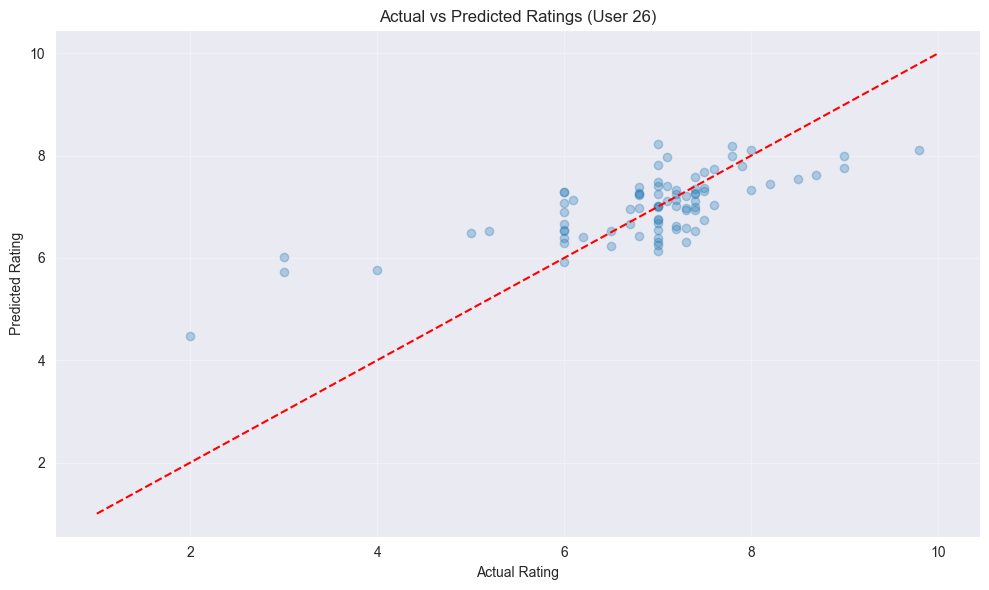

In [5]:
# Analyze a single user
user_id = train_data['UserId'][0]
prediction_df = analyze_user_predictions(user_id)

print("Prediction Results:")
print(prediction_df)

plot_predictions(prediction_df, f'Actual vs Predicted Ratings (User {user_id})')

In [6]:
# Get recommendations with selected attributes
detailed_recs = instance.get_recommendations(user_id, n=10,
                                             attributes=['Name', 'YearPublished', 'AvgRating', 'NumUserRatings',
                                                            'Rank:boardgame'])
pd.DataFrame(detailed_recs)

,BGGId,PredictedRating,Name,YearPublished,AvgRating,NumUserRatings,Rank:boardgame
0,266507,8.631072,Clank!: Legacy – Acquisitions Incorporated,2019,8.69604,4722,34
1,246900,8.528667,Eclipse: Second Dawn for the Galaxy,2020,8.67526,4996,46
2,284378,8.357363,Kanban EV,2020,8.62853,2791,139
3,270633,8.330780,Aeon's End: The New Age,2019,8.67759,1725,376
4,169427,8.298292,Middara: Unintentional Malum – Act 1,2019,8.84724,1544,545
5,291457,8.297604,Gloomhaven: Jaws of the Lion,2020,8.69610,15062,6
6,55690,8.257158,Kingdom Death: Monster,2015,8.61012,8012,50
7,161936,8.253120,Pandemic Legacy: Season 1,2015,8.59678,44614,2
8,262211,8.180609,Cloudspire,2019,8.26495,2025,505
9,233078,8.169130,Twilight Imperium: Fourth Edition,2017,8.67916,15736,5


In [7]:
# Analyze sample of users (100 max)
print("Analyzing sample of users...")
all_predictions_df = analyze_users(max_users=1000)


Analyzing sample of users...


In [8]:
# Calculate performance metrics
rmse = np.sqrt((all_predictions_df['Error'] ** 2).mean())
mae = all_predictions_df['Error'].abs().mean()
corr = np.corrcoef(all_predictions_df['Actual'], all_predictions_df['Predicted'])[0, 1]

print(f"Performance Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Correlation: {corr:.4f}")


Performance Metrics:
RMSE: 1.1770
MAE: 0.8809
Correlation: 0.5899


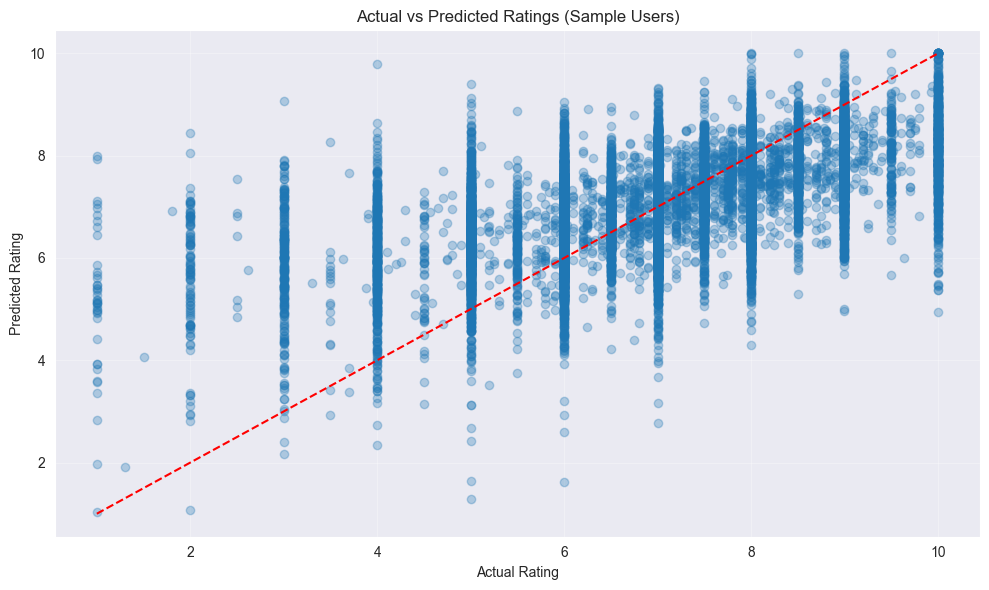

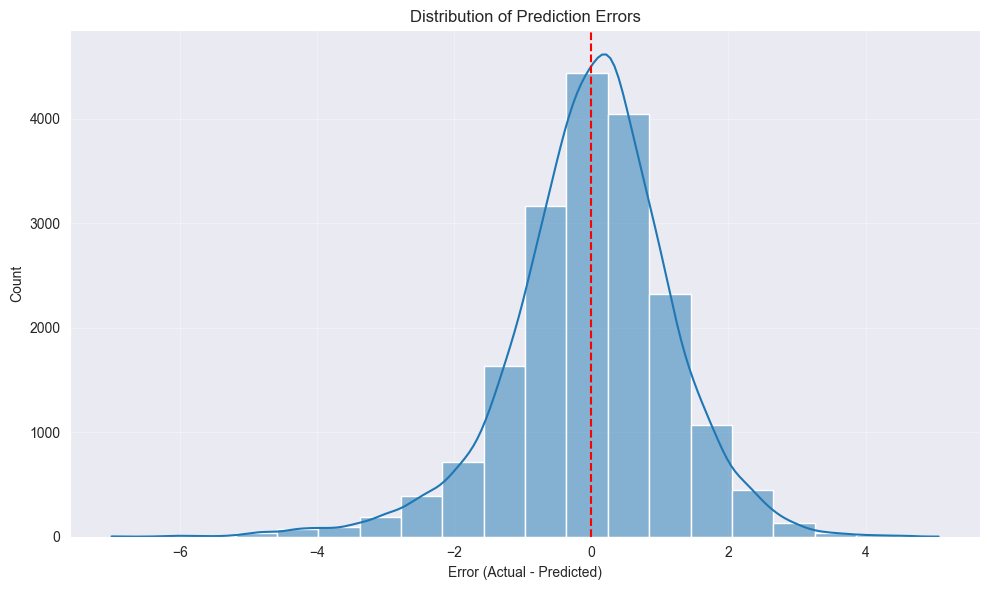

In [9]:
# Visualize overall results
plot_predictions(all_predictions_df, 'Actual vs Predicted Ratings (Sample Users)')
plot_error_distribution(all_predictions_df)


In [10]:
# Compare popular vs personalized recommendations
popular_items = instance.get_popular_recommendations(train_data, 10)
popular_df = pd.DataFrame(popular_items, columns=['ItemId', 'Score'])

print("Popular Recommendations:")
print(popular_df)

# Compare with a specific user's recommendations
personal_recs = instance.get_recommendations(user_id)
personal_rec_ids = [rec['BGGId'] for rec in personal_recs]
overlap = len(set(personal_rec_ids).intersection(set(popular_df['ItemId'])))

print(f"\nUser {user_id} Recommendations:")
print(pd.DataFrame(personal_recs))
print(f"\nOverlap with popular items: {overlap} items")


Popular Recommendations:
   ItemId      Score
0  167791  46.576445
1   68448  45.071618
2   30549  44.883919
3  169786  44.804702
4     822  44.289854
5  173346  43.926876
6  161936  43.883380
7  174430  43.710994
8   84876  43.657031
9    3076  43.338779

User 26 Recommendations:
    BGGId  PredictedRating
0  266507         8.631072
1  246900         8.528667
2  284378         8.357363
3  270633         8.330780
4  169427         8.298292
5  291457         8.297604
6   55690         8.257158
7  161936         8.253120
8  262211         8.180609
9  233078         8.169130

Overlap with popular items: 1 items
